# configure spark variables

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.context import  SQLContext

In [3]:
sc=SparkContext()
sqlContext=SQLContext(sc)
spark=SparkSession(sc)

23/03/01 11:57:48 WARN Utils: Your hostname, Satyam resolves to a loopback address: 127.0.1.1; using 192.168.141.112 instead (on interface wlp19s0)
23/03/01 11:57:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/01 11:57:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# load up other dependencies

In [4]:
import re
import pandas as pd

Working with regular expressions will be one of the major aspects of parsing log files.Regular expressions are a really powerful pattern matching technique which can be used to extract and find patterns in semi-structured and unstructured data.

### How Regular Expression works: example

In [5]:
# m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
# for match in m:
#     print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


# Loading and Viewing the Log Dataset

In [6]:
import glob

raw_data_files = glob.glob('Data/nginx-feb2023/nginx/*gz')

In [7]:
raw_data_files

['Data/nginx-feb2023/nginx/proxy.log-20230220.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230221.gz',
 'Data/nginx-feb2023/nginx/error.log-20230218.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230216.gz',
 'Data/nginx-feb2023/nginx/error.log-20230213.gz',
 'Data/nginx-feb2023/nginx/access.log-20230220.gz',
 'Data/nginx-feb2023/nginx/error.log-20230215.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230215.gz',
 'Data/nginx-feb2023/nginx/error.log-20230216.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230218.gz',
 'Data/nginx-feb2023/nginx/error.log-20230222.gz',
 'Data/nginx-feb2023/nginx/error.log-20230220.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230219.gz',
 'Data/nginx-feb2023/nginx/error.log-20230221.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230217.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230222.gz',
 'Data/nginx-feb2023/nginx/access.log-20230213.gz',
 'Data/nginx-feb2023/nginx/proxy.log-20230213.gz',
 'Data/nginx-feb2023/nginx/error.log-20230217.gz',
 'Data/nginx-feb2023/nginx/er

we’ll use sqlContext.read.text() or spark.read.text() to read the text file. This will produce a DataFrame with a single string column called value.

In [8]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [9]:
type(base_df)

pyspark.sql.dataframe.DataFrame

In [10]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

In [11]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                        |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|143.244.50.172 - - [16/Feb/2023:03:28:4

In [12]:
base_df_rdd.take(10)

[Row(value='143.244.50.172 - - [16/Feb/2023:03:28:45 +0530] "GET /config/getuser?index=0 HTTP/1.1" 400 248 "-" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0"'),
 Row(value='164.90.235.116 - - [16/Feb/2023:04:11:34 +0530] "GET / HTTP/1.1" 200 5952 "http://14.139.152.12/" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"'),
 Row(value='66.249.69.126 - - [16/Feb/2023:04:39:52 +0530] "GET /robots.txt HTTP/1.1" 404 146 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"'),
 Row(value='66.249.69.126 - - [16/Feb/2023:04:39:52 +0530] "GET /assets/img/favicon.png HTTP/1.1" 200 491 "-" "Googlebot-Image/1.0"'),
 Row(value='185.221.219.172 - - [16/Feb/2023:05:06:47 +0530] "GET /.git/config HTTP/1.1" 404 548 "-" "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.2; Trident/5.0)"'),
 Row(value='66.249.69.101 - - [16/Feb/2023:05:24:52 +0530] "GET /apim/devportal/site/public/images/

# Data Wrangling

In [13]:
print((base_df.count(), len(base_df.columns)))

(6218, 1)


In [14]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['143.244.50.172 - - [16/Feb/2023:03:28:45 +0530] "GET /config/getuser?index=0 HTTP/1.1" 400 248 "-" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0"',
 '164.90.235.116 - - [16/Feb/2023:04:11:34 +0530] "GET / HTTP/1.1" 200 5952 "http://14.139.152.12/" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"',
 '66.249.69.126 - - [16/Feb/2023:04:39:52 +0530] "GET /robots.txt HTTP/1.1" 404 146 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"',
 '66.249.69.126 - - [16/Feb/2023:04:39:52 +0530] "GET /assets/img/favicon.png HTTP/1.1" 200 491 "-" "Googlebot-Image/1.0"',
 '185.221.219.172 - - [16/Feb/2023:05:06:47 +0530] "GET /.git/config HTTP/1.1" 404 548 "-" "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.2; Trident/5.0)"',
 '66.249.69.101 - - [16/Feb/2023:05:24:52 +0530] "GET /apim/devportal/site/public/images/logo.svg HTTP/1.1" 304 0 "-" "Googlebot-Image/1.0"',
 '52.167.144

## Extracting host names

In [15]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['143.244.50.172',
 '164.90.235.116',
 '66.249.69.126',
 '66.249.69.126',
 '185.221.219.172',
 '66.249.69.101',
 '52.167.144.90',
 '152.89.196.211',
 '114.119.133.53',
 '198.20.69.98',
 '198.20.69.98',
 '198.20.69.98',
 '198.20.69.98',
 '198.20.69.98',
 '198.20.69.98']

## Extracting timestamps

In [16]:
#ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} \d{4})'
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2})'
timestamps = [re.search(ts_pattern, item).group(1)
              for item in sample_logs]
timestamps

['16/Feb/2023:03:28:45',
 '16/Feb/2023:04:11:34',
 '16/Feb/2023:04:39:52',
 '16/Feb/2023:04:39:52',
 '16/Feb/2023:05:06:47',
 '16/Feb/2023:05:24:52',
 '16/Feb/2023:06:26:16',
 '16/Feb/2023:07:00:15',
 '16/Feb/2023:07:01:52',
 '16/Feb/2023:07:26:00',
 '16/Feb/2023:07:26:16',
 '16/Feb/2023:07:26:20',
 '16/Feb/2023:07:26:21',
 '16/Feb/2023:07:26:24',
 '16/Feb/2023:07:26:30']

## Extracting HTTP Request Method, URIs and Protocol

In [17]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/config/getuser?index=0', 'HTTP/1.1'),
 ('GET', '/', 'HTTP/1.1'),
 ('GET', '/robots.txt', 'HTTP/1.1'),
 ('GET', '/assets/img/favicon.png', 'HTTP/1.1'),
 ('GET', '/.git/config', 'HTTP/1.1'),
 ('GET', '/apim/devportal/site/public/images/logo.svg', 'HTTP/1.1'),
 ('GET', '/', 'HTTP/1.1'),
 ('GET', '/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php', 'HTTP/1.1'),
 ('GET', '/robots.txt', 'HTTP/1.1'),
 ('GET', '/', 'HTTP/1.1'),
 ('-"', '"-', ''),
 ('-"', '"-', ''),
 ('-"', '"-', ''),
 ('-"', '"-', ''),
 ('GET', '/robots.txt', 'HTTP/1.1')]

## Extracting HTTP Status Codes

In [18]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['400', '200', '404', '200', '404', '304', '200', '404', '404', '200', '400', '400', '400', '400', '404']


## Extracting HTTP Response Content Size

In [19]:
#content_size_pattern = r'\s(\d+)$'
content_size_pattern = r'\s(\d+) "'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['248', '5952', '146', '491', '548', '0', '5952', '548', '146', '5952', '0', '0', '0', '0', '146']


# Putting it all together

Let’s now try and leverage all the regular expression patterns we previously built and use the regexp_extract(...) method to build our dataframe with all the log attributes neatly extracted in their own separate columns.

In [20]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+---------------+--------------------+------+--------------------+--------+------+------------+
|           host|           timestamp|method|            endpoint|protocol|status|content_size|
+---------------+--------------------+------+--------------------+--------+------+------------+
| 143.244.50.172|16/Feb/2023:03:28:45|   GET|/config/getuser?i...|HTTP/1.1|   400|         248|
| 164.90.235.116|16/Feb/2023:04:11:34|   GET|                   /|HTTP/1.1|   200|        5952|
|  66.249.69.126|16/Feb/2023:04:39:52|   GET|         /robots.txt|HTTP/1.1|   404|         146|
|  66.249.69.126|16/Feb/2023:04:39:52|   GET|/assets/img/favic...|HTTP/1.1|   200|         491|
|185.221.219.172|16/Feb/2023:05:06:47|   GET|        /.git/config|HTTP/1.1|   404|         548|
|  66.249.69.101|16/Feb/2023:05:24:52|   GET|/apim/devportal/s...|HTTP/1.1|   304|           0|
|  52.167.144.90|16/Feb/2023:06:26:16|   GET|                   /|HTTP/1.1|   200|        5952|
| 152.89.196.211|16/Feb/2023:07:00:15|  

In [21]:
panda_logs_df=logs_df.toPandas()

In [22]:
panda_logs_df.isnull().sum()

host              0
timestamp         0
method            0
endpoint          0
protocol          0
status          482
content_size    482
dtype: int64

In [23]:
panda_logs_df.columns

Index(['host', 'timestamp', 'method', 'endpoint', 'protocol', 'status',
       'content_size'],
      dtype='object')

In [24]:
panda_logs_df['host'].value_counts()

95.57.152.188     549
                  482
122.50.208.20     282
183.136.225.32    198
193.42.33.24      197
                 ... 
192.241.229.25      1
182.59.123.87       1
198.235.24.132      1
42.235.133.126      1
185.46.222.83       1
Name: host, Length: 766, dtype: int64

In [25]:
panda_logs_df['timestamp'].value_counts()

                        482
20/Feb/2023:17:22:32     37
21/Feb/2023:05:03:03     36
14/Feb/2023:13:30:25     35
14/Feb/2023:17:30:33     35
                       ... 
12/Feb/2023:08:01:01      1
12/Feb/2023:08:01:09      1
12/Feb/2023:08:01:13      1
12/Feb/2023:08:16:51      1
14/Feb/2023:21:17:27      1
Name: timestamp, Length: 3659, dtype: int64

In [26]:
panda_logs_df['endpoint'].value_counts()

/                                                  947
"-"                                                716
/boaform/admin/formLogin                           574
www.msftncsi.com:443                               545
/robots.txt                                        168
                                                  ... 
/phpmyadmin2018/index.php?lang=en                    1
/program/index.php?lang=en                           1
/2phpmyadmin/index.php?lang=en                       1
/_phpmyadmin/index.php?lang=en                       1
/boaform/admin/formLogin?username=user&psd=user      1
Name: endpoint, Length: 583, dtype: int64

In [27]:
panda_logs_df['protocol'].value_counts()

HTTP/1.1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    5200
"-                                                                                                                     

In [28]:
panda_logs_df['status'].value_counts()

301.0    1948
400.0    1658
200.0    1605
404.0     486
302.0      12
405.0      11
206.0      10
204.0       4
304.0       1
500.0       1
Name: status, dtype: int64

In [29]:
panda_logs_df['content_size'].value_counts()

169.0       1942
150.0        681
0.0          619
5952.0       393
157.0        310
            ... 
359963.0       1
458267.0       1
687643.0       1
425499.0       1
605728.0       1
Name: content_size, Length: 122, dtype: int64

# Finding Missing Values

In [30]:
(base_df.filter(base_df['value'].isNull()).count())

0

##  testing for all possible null values

In [31]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

482

## Finding Null Counts

In [32]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|   482|         482|
+----+---------+------+--------+--------+------+------------+



In [33]:
regexp_extract('value', r'\s(\d{3})\s', 1).cast('integer').alias( 'status')

Column<'CAST(regexp_extract(value, \s(\d{3})\s, 1) AS INT) AS status'>

In [34]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

482

In [35]:
null_status_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                              |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### passing missing information through our log data parsing pipeline.

In [36]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+-------------------------------------------------------------------------------------------------------+--------+------+------------+
|host|timestamp|method|endpoint                                                                                               |protocol|status|content_size|
+----+---------+------+-------------------------------------------------------------------------------------------------------+--------+------+------------+
|    |         |GET   |/manager/html                                                                                          |HTTP/1.1|null  |null        |
|    |         |GET   |/sitemap.xml                                                                                           |HTTP/1.1|null  |null        |
|    |         |GET   |/robots.txt                                                                                            |HTTP/1.1|null  |null        |
|    |         |GET   |/sitemap.xml                       

In [37]:
logs_df = logs_df[logs_df['status'].isNotNull()]
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



In [38]:
regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')

Column<'CAST(regexp_extract(value, \s(\d+)$, 1) AS INT) AS content_size'>

In [39]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

6218

In [40]:
null_content_size_df.take(10)

[Row(value='143.244.50.172 - - [16/Feb/2023:03:28:45 +0530] "GET /config/getuser?index=0 HTTP/1.1" 400 248 "-" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0"'),
 Row(value='164.90.235.116 - - [16/Feb/2023:04:11:34 +0530] "GET / HTTP/1.1" 200 5952 "http://14.139.152.12/" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"'),
 Row(value='66.249.69.126 - - [16/Feb/2023:04:39:52 +0530] "GET /robots.txt HTTP/1.1" 404 146 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"'),
 Row(value='66.249.69.126 - - [16/Feb/2023:04:39:52 +0530] "GET /assets/img/favicon.png HTTP/1.1" 200 491 "-" "Googlebot-Image/1.0"'),
 Row(value='185.221.219.172 - - [16/Feb/2023:05:06:47 +0530] "GET /.git/config HTTP/1.1" 404 548 "-" "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.2; Trident/5.0)"'),
 Row(value='66.249.69.101 - - [16/Feb/2023:05:24:52 +0530] "GET /apim/devportal/site/public/images/

It is quite evident that the bad raw data records correspond to error responses, where no content was sent back and the server emitted a “-" for the content_size field.

In [41]:
logs_df = logs_df.na.fill({'content_size': 0})
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



In [42]:
logs_df.show(20)

+---------------+--------------------+------+--------------------+--------+------+------------+
|           host|           timestamp|method|            endpoint|protocol|status|content_size|
+---------------+--------------------+------+--------------------+--------+------+------------+
| 143.244.50.172|16/Feb/2023:03:28:45|   GET|/config/getuser?i...|HTTP/1.1|   400|         248|
| 164.90.235.116|16/Feb/2023:04:11:34|   GET|                   /|HTTP/1.1|   200|        5952|
|  66.249.69.126|16/Feb/2023:04:39:52|   GET|         /robots.txt|HTTP/1.1|   404|         146|
|  66.249.69.126|16/Feb/2023:04:39:52|   GET|/assets/img/favic...|HTTP/1.1|   200|         491|
|185.221.219.172|16/Feb/2023:05:06:47|   GET|        /.git/config|HTTP/1.1|   404|         548|
|  66.249.69.101|16/Feb/2023:05:24:52|   GET|/apim/devportal/s...|HTTP/1.1|   304|           0|
|  52.167.144.90|16/Feb/2023:06:26:16|   GET|                   /|HTTP/1.1|   200|        5952|
| 152.89.196.211|16/Feb/2023:07:00:15|  

In [43]:
logs_df

DataFrame[host: string, timestamp: string, method: string, endpoint: string, protocol: string, status: int, content_size: int]

In [44]:
logs_df.count()

5736

# Handling Temporal Fields (Timestamp)

we have to parse the timestamp field into an actual timestamp. The Common Log Format time is somewhat non-standard. A User-Defined Function (UDF) is the most straightforward way to parse it.

In [45]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [46]:
udf_parse_time = udf(parse_clf_time)
logs_df = (logs_df.select('*', udf_parse_time(logs_df['timestamp'])
                                  .cast('timestamp')
                                  .alias('time'))
                  .drop('timestamp'))

In [47]:
logs_df.show(10,truncate=True)

+---------------+------+--------------------+--------+------+------------+-------------------+
|           host|method|            endpoint|protocol|status|content_size|               time|
+---------------+------+--------------------+--------+------+------------+-------------------+
| 143.244.50.172|   GET|/config/getuser?i...|HTTP/1.1|   400|         248|2023-02-16 03:28:45|
| 164.90.235.116|   GET|                   /|HTTP/1.1|   200|        5952|2023-02-16 04:11:34|
|  66.249.69.126|   GET|         /robots.txt|HTTP/1.1|   404|         146|2023-02-16 04:39:52|
|  66.249.69.126|   GET|/assets/img/favic...|HTTP/1.1|   200|         491|2023-02-16 04:39:52|
|185.221.219.172|   GET|        /.git/config|HTTP/1.1|   404|         548|2023-02-16 05:06:47|
|  66.249.69.101|   GET|/apim/devportal/s...|HTTP/1.1|   304|           0|2023-02-16 05:24:52|
|  52.167.144.90|   GET|                   /|HTTP/1.1|   200|        5952|2023-02-16 06:26:16|
| 152.89.196.211|   GET|/vendor/phpunit/p...|HTTP/

In [48]:
logs_df.toPandas().to_csv('log_niginx.csv')

# HTTP code analysis

In [100]:

status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
print('Total distinct HTTP Status Codes:', status_freq_df.count())  

23/03/01 12:35:38 WARN CacheManager: Asked to cache already cached data.
Total distinct HTTP Status Codes: 10


In [101]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
3,301,1948
6,400,1658
0,200,1605
7,404,486
4,302,12
8,405,11
2,206,10
1,204,4
5,304,1
9,500,1


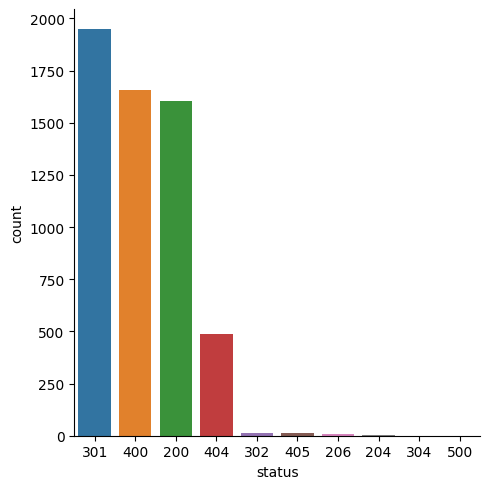

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

## 300 Moved Permanently is used for permanent redirecting, meaning that links or records returning this response should be updated.
## 400 Bad Request response status code indicates that the server cannot or will not process the request due to something that is perceived to be a client error 

# handling the skewness

In [106]:
from pyspark.sql import functions as F
log_freq_df = status_freq_df.withColumn('log(count)', 
                                        F.log(status_freq_df['count']))
log_freq_df.show()

+------+-----+------------------+
|status|count|        log(count)|
+------+-----+------------------+
|   200| 1605| 7.380879035564116|
|   204|    4|1.3862943611198906|
|   206|   10| 2.302585092994046|
|   301| 1948|7.5745584842024805|
|   302|   12|2.4849066497880004|
|   304|    1|               0.0|
|   400| 1658|7.4133673356952405|
|   404|  486| 6.186208623900494|
|   405|   11|2.3978952727983707|
|   500|    1|               0.0|
+------+-----+------------------+



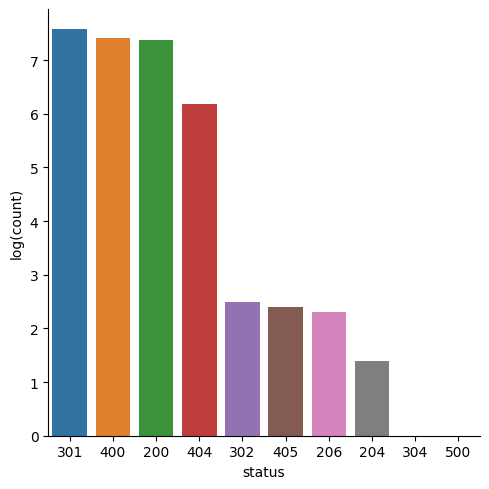

In [107]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

# Analyzing 20 Frequent Hosts

In [113]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(20))

host_sum_df.show(truncate=False)

+--------------+-----+
|host          |count|
+--------------+-----+
|95.57.152.188 |549  |
|122.50.208.20 |282  |
|183.136.225.32|198  |
|193.42.33.24  |197  |
|194.87.151.209|196  |
|212.87.204.248|132  |
|10.180.6.83   |129  |
|146.59.227.0  |127  |
|45.88.67.120  |102  |
|109.237.98.226|101  |
|79.110.62.234 |84   |
|152.89.196.211|84   |
|193.32.162.159|80   |
|157.50.69.17  |78   |
|20.68.180.129 |74   |
|141.255.166.82|74   |
|49.36.17.16   |74   |
|109.237.97.180|73   |
|143.244.50.172|62   |
|94.102.61.10  |50   |
+--------------+-----+



# Top 20 Frequent EndPoints

In [116]:

paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

paths_pd_df = paths_df.toPandas()
paths_pd_df 

,endpoint,count
0,/,947
1,"""-""",716
2,/boaform/admin/formLogin,574
3,www.msftncsi.com:443,545
4,/assets/img/favicon.png,106
5,/robots.txt,99
6,"""-",62
7,/.env,61
8,/assets/img/apple-touch-icon.png,55
9,/config/getuser?index=0,54


# Top 20 Error Endpoints(non-200 code)

In [120]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(20)
                          )
                          
error_endpoints_freq_df.show(truncate=False)  

+------------------------+-----+
|endpoint                |count|
+------------------------+-----+
|"-"                     |716  |
|/                       |584  |
|/boaform/admin/formLogin|574  |
|www.msftncsi.com:443    |545  |
|/robots.txt             |99   |
|"-                      |62   |
|/.env                   |61   |
|/config/getuser?index=0 |54   |
|/favicon.ico            |52   |
|*                       |40   |
|mstshash=Domain         |28   |
|mstshash=Administr      |25   |
|/actuator/gateway/routes|24   |
|/.aws/credentials       |18   |
|http://ip-api.com/json/ |18   |
|/assets/img/favicon.png |17   |
|/laravel/.env           |17   |
|/phpinfo                |16   |
|ip-api.com:443          |16   |
|/web/.env               |16   |
+------------------------+-----+



# Unique Hosts

In [125]:
unique_host_count = (logs_df
            .select('host')
            .distinct()
            .groupBy('host')
            .count()
            .sort('count', ascending=False).limit(20))

unique_host_count_df = unique_host_count.toPandas()
unique_host_count_df            

,host,count
0,128.14.134.170,1
1,104.248.193.100,1
2,118.123.105.85,1
3,143.42.102.54,1
4,45.155.126.211,1
5,66.102.6.247,1
6,95.57.152.188,1
7,66.249.66.4,1
8,170.64.146.220,1
9,10.180.6.83,1


# Total No. of unique Host

In [126]:
unique_host_no = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_no

765

# Number of Unique Daily Hosts

Since the log only covers a single month, we can ignore the month. 

we can use the dayofmonthfunction in the pyspark.sql.functions module (which we have already imported as F.

In [127]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+---------------+---+
|host           |day|
+---------------+---+
|143.244.50.172 |16 |
|164.90.235.116 |16 |
|66.249.69.126  |16 |
|66.249.69.126  |16 |
|185.221.219.172|16 |
+---------------+---+
only showing top 5 rows



In [128]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+--------------+---+
|host          |day|
+--------------+---+
|66.102.9.214  |16 |
|198.235.24.48 |17 |
|185.246.220.98|17 |
|106.75.175.25 |14 |
|170.64.130.58 |21 |
+--------------+---+
only showing top 5 rows



In [131]:
#def_mr = pd.get_option('max_rows')
#pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,12,79
1,13,89
2,14,105
3,15,120
4,16,97
5,17,140
6,18,94
7,19,95
8,20,106
9,21,126


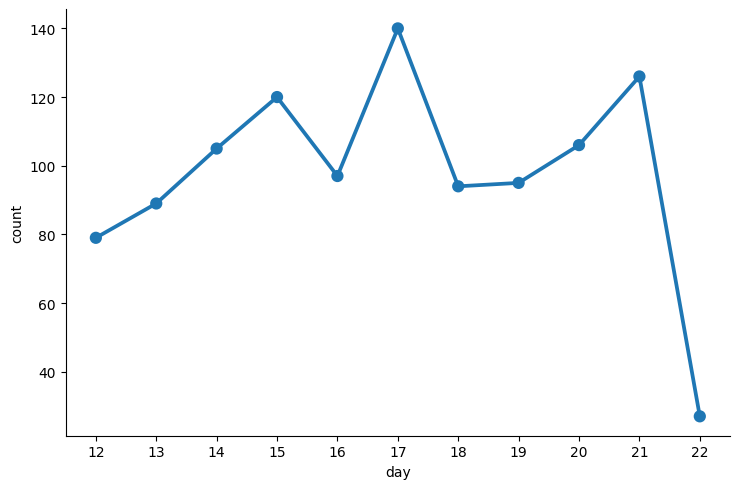

In [132]:
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

# Average Number of Daily Requests per Host

In [134]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

daily_hosts_df.show()

+---+-----------+
|day|total_hosts|
+---+-----------+
| 12|         79|
| 22|         27|
| 13|         89|
| 16|         97|
| 20|        106|
| 19|         95|
| 15|        120|
| 17|        140|
| 21|        126|
| 14|        105|
| 18|         94|
+---+-----------+



In [135]:
total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))
total_daily_reqests_df.show()

+---+----------+
|day|total_reqs|
+---+----------+
| 12|       861|
| 22|       108|
| 13|       350|
| 16|       726|
| 15|       563|
| 17|       457|
| 21|       659|
| 14|       623|
| 18|       282|
| 20|       579|
| 19|       528|
+---+----------+



In [136]:
avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,12,861,79,10.898734
1,13,350,89,3.932584
2,14,623,105,5.933333
3,15,563,120,4.691667
4,16,726,97,7.484536
5,17,457,140,3.264286
6,18,282,94,3.000000
7,19,528,95,5.557895
8,20,579,106,5.462264
9,21,659,126,5.230159


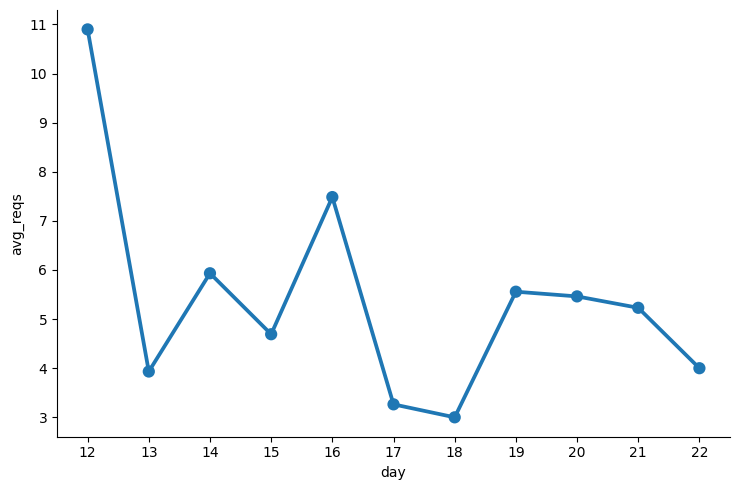

In [140]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

# Total 404 Response Codes

In [147]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

23/03/01 14:49:24 WARN CacheManager: Asked to cache already cached data.
Total 404 responses: 486


# Listing the Top Twenty 404 Response Code Endpoints

In [151]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+----------------------------------------------------------------------+-----+
|endpoint                                                              |count|
+----------------------------------------------------------------------+-----+
|/robots.txt                                                           |69   |
|/favicon.ico                                                          |46   |
|/actuator/gateway/routes                                              |16   |
|/.env                                                                 |16   |
|/sitemap.xml                                                          |12   |
|/owa/auth/logon.aspx?url=https%3a%2f%2f1%2fecp%2f                     |10   |
|/.git/config                                                          |9    |
|/wp-login.php                                                         |7    |
|/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php                   |7    |
|/.well-known/security.txt                          

# Listing the Top Twenty 404 Response Code Hosts

In [149]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------+-----+
|host           |count|
+---------------+-----+
|20.68.180.129  |50   |
|141.255.166.82 |37   |
|152.89.196.211 |30   |
|51.15.27.89    |16   |
|164.92.189.255 |15   |
|182.66.82.11   |13   |
|104.248.193.100|12   |
|54.235.59.67   |12   |
|44.200.66.190  |12   |
|3.97.47.30     |9    |
|163.172.117.134|7    |
|52.167.144.57  |6    |
|47.243.233.244 |6    |
|148.153.45.234 |6    |
|185.180.143.141|5    |
|183.136.225.32 |5    |
|45.148.120.161 |5    |
|185.180.143.18 |5    |
|106.75.80.230  |5    |
|109.237.98.226 |4    |
+---------------+-----+



# Visualizing 404 Errors per Day

In [152]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,12,16
1,13,31
2,14,35
3,15,55
4,16,45
5,17,40
6,18,34
7,19,103
8,20,28
9,21,81


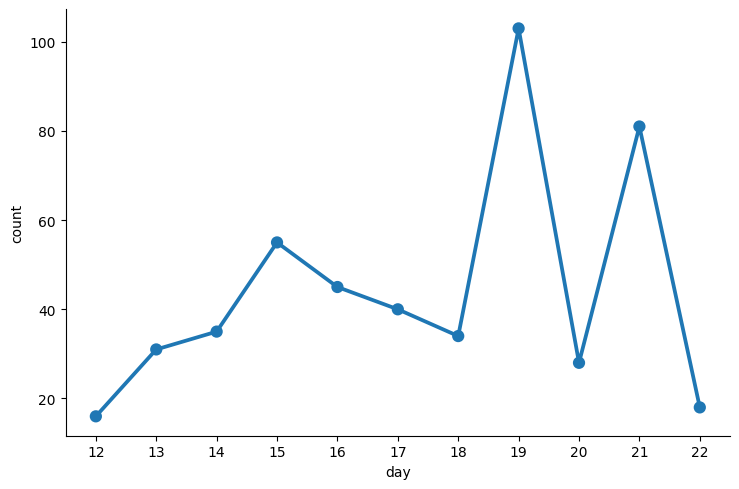

In [153]:
c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

# Top Three Days for 404 Errors

In [154]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
| 19|  103|
| 21|   81|
| 15|   55|
+---+-----+
only showing top 3 rows



# Visualizing Hourly 404 Errors

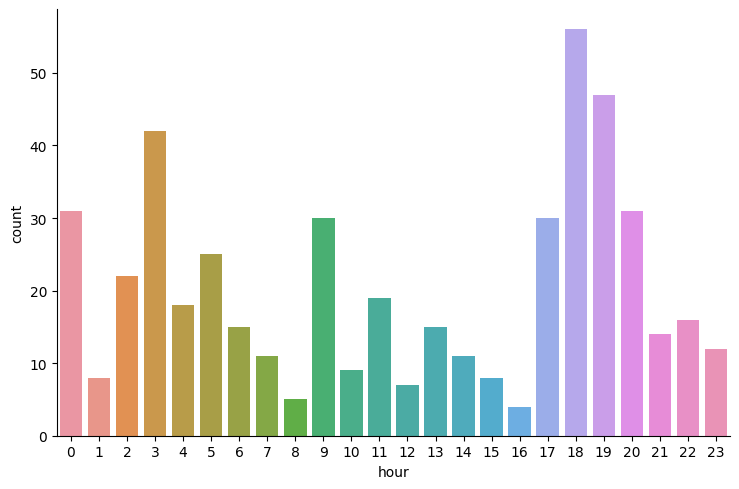

In [156]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

In [194]:
df=pd.read_csv('log_niginx.csv')

In [196]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df

,host,method,endpoint,protocol,status,content_size,time
0,143.244.50.172,GET,/config/getuser?index=0,HTTP/1.1,400,248,2023-02-16 03:28:45
1,164.90.235.116,GET,/,HTTP/1.1,200,5952,2023-02-16 04:11:34
2,66.249.69.126,GET,/robots.txt,HTTP/1.1,404,146,2023-02-16 04:39:52
3,66.249.69.126,GET,/assets/img/favicon.png,HTTP/1.1,200,491,2023-02-16 04:39:52
4,185.221.219.172,GET,/.git/config,HTTP/1.1,404,548,2023-02-16 05:06:47
...,...,...,...,...,...,...,...
5731,154.12.227.174,POST,/core/.env,HTTP/1.1,404,146,2023-02-19 02:48:08
5732,154.12.227.174,GET,/core/.env,HTTP/1.1,404,146,2023-02-19 02:48:10
5733,154.12.227.174,POST,/,HTTP/1.1,405,150,2023-02-19 02:48:12
5734,154.12.227.174,POST,/core/.env,HTTP/1.1,404,146,2023-02-19 02:48:13


# Conclusion

# Encoding Columns for predictive analysis

In [199]:
from sklearn.preprocessing import LabelEncoder
label_df=df.apply(LabelEncoder().fit_transform)

In [202]:
label_df.to_csv('log_niginx_labeled.csv')